In [3]:
# !pip install zarr
# ! echo zarr > requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 71.0 MB/s eta 0:00:00:00:0100:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=00a5e350709ff8428e5821e7ebc00d30d877e0351b4a5270896078104f345296
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [4]:
import os
import json
import zarr
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim

In [5]:
protein_names = ['apo-ferritin.json', 'virus-like-particle.json', 'ribosome.json', 'beta-amylase.json', 'beta-galactosidase.json', 'thyroglobulin.json']
    
protein_names_no_json = ['apo-ferritin', 'virus-like-particle', 'ribosome', 'beta-amylase', 'beta-galactosidase', 'thyroglobulin']

protein_index_dict = {protein_name: index for index, protein_name in enumerate(protein_names)}

In [6]:
def prepare_train_data(imagecase, imagetype):

    image = zarr.open('/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'+imagecase+'/VoxelSpacing10.000/'+imagetype+'.zarr', mode='r')
    
    # path to train ground truth
    path = ('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'+imagecase+'/Picks')
    
    #################################################################################################################################################################
    
    # Prepare data 
    filenames = [
        'apo-ferritin.json',
        'virus-like-particle.json',
        'ribosome.json',
        'beta-amylase.json',
        'thyroglobulin.json',
        'beta-galactosidase.json'
    ]
    json_data = {}
    for filename in filenames:
        file_path = os.path.join(path, filename)
    
        with open(file_path, 'r') as file:
            json_data[filename] = json.load(file)
    json_data.keys()
    
    #################################################################################################################################################################
    
    particle_data = {}
    for filename in filenames:
        file_path = os.path.join(path, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
    
            points = data.get('points', [])
            transformation = np.array(data.get('transformation_', np.eye(4)))  # Default to identity if no transformation is provided
            particle_data[filename] = {
                'transformation': transformation,
                'particles': []
            }
            for point in points:
                location = point['location']
                # Append the (x, y, z) coordinates of the particle
                particle_data[filename]['particles'].append((location['x'], location['y'], location['z']))
    #################################################################################################################################################################
        
    all_proteins_df = pd.DataFrame(columns=['x', 'y', 'z', 'particle_type'])
    particles = []
    
    # Iterate through the particle data to add each protein data to the DataFrame
    for protein_name, protein_data in particle_data.items():
        transformation = protein_data['transformation']
        particles = protein_data['particles']
        
        transformed_particles = []
        for particle in particles:
            # Convert particle to homogeneous coordinates (x, y, z, 1)
            homogenous_particle = np.array([*particle, 1.0])
            transformed_particle = np.dot(transformation, homogenous_particle)
            transformed_particles.append(transformed_particle[:3])  
        transformed_particles = np.array(transformed_particles)
    
        particles = transformed_particles
        
        
        # Create a temporary DataFrame for the current protein
        temp_df = pd.DataFrame(particles, columns=['x', 'y', 'z'])
        temp_df['particle_type'] = protein_index_dict.get(protein_name)
        
        # Append the temporary DataFrame to the main DataFrame
        all_proteins_df = pd.concat([all_proteins_df, temp_df], ignore_index=True)
    
    # Display the final DataFrame
    # print(all_proteins_df)
    return all_proteins_df, image

In [7]:
def plotData(all_proteins_df):

    color_map = {
        0: 'red',         # Color for particle type 1
        1: 'blue',        # Color for particle type 2
        2: 'green',       # Color for particle type 3
        3: 'orange',      # Color for particle type 4
        4: 'purple',      # Color for particle type 5
        5: 'yellow'
    }
    
    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Iterate through the rows of the DataFrame
    for index, row in all_proteins_df.iterrows():
        # Extract coordinates and particle type
        x = row['x']
        y = row['y']
        z = row['z']
        particle_type = row['particle_type']

        #######################################OPTIONAL****************************************
        # Print the particle information
        # print(f"Particle Type: {particle_type}, X: {x}, Y: {y}, Z: {z}")
        
        # Choose the color based on the particle type
        color = color_map.get(particle_type, 'black')  # Default to black if type is not in the map
        
        # Plot the data points with corresponding color
        ax.scatter(x, y, z, color=color)

    # Set labels and title
    ax.set_title("Particle Locations and Types")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Display the legend with particle types
    handles = []
    for particle_type, color in color_map.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'{protein_names_no_json[particle_type]}'))

    ax.legend(handles=handles)

    # Show the plot
    plt.show()

In [8]:
def check_image_data_shape(image):
    # List the keys (datasets or arrays) in the Zarr group by calling keys()
    print(list(image.keys()))
    
    # Assuming you want to check the shape of the dataset with the highest resolution
    print(f"Shape of {image}: {image[0].shape}")

In [9]:
def check_image(image):

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(30,30))
    for i in range(5):
        ax = plt.subplot(20, 20, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[0][i])

/tmp/ipykernel_30/3964937058.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_proteins_df = pd.concat([all_proteins_df, temp_df], ignore_index=True)


['0', '1', '2']
Shape of <zarr.hierarchy.Group '/' read-only>: (184, 630, 630)


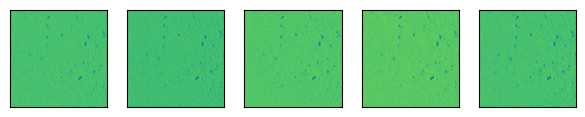

In [10]:
imagecase = 'TS_6_6'
imagetype = 'denoised'
all_proteins_df, image = prepare_train_data(imagecase, imagetype)

check_image_data_shape(image)
check_image(image)

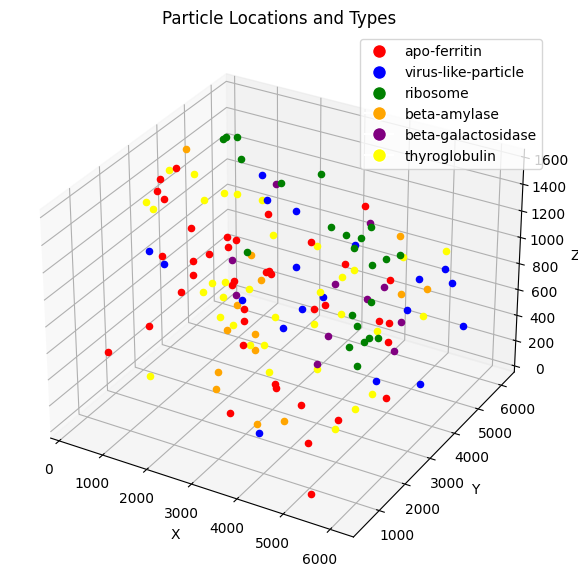

In [11]:
plotData(all_proteins_df)

{'x': 5086.352, 'y': 6157.563, 'z': 696.444}
{'x': 5157.398, 'y': 4441.079, 'z': 683.717}


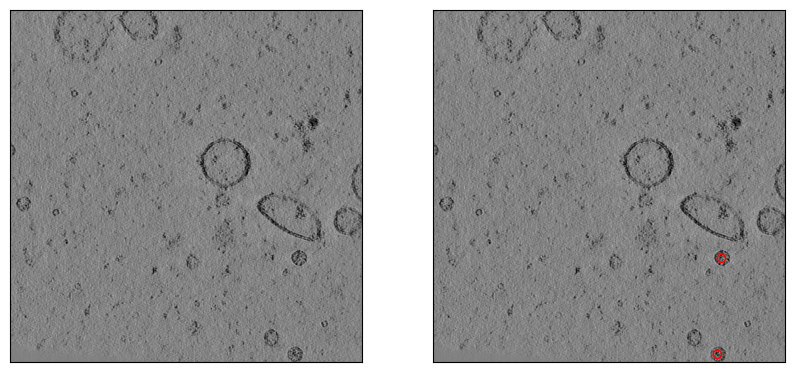

In [12]:
def Correlate_tomogram_with_protein_location():
    protein_names_no_json = ['apo-ferritin', 'virus-like-particle', 'ribosome', 'beta-amylase', 'beta-galactosidase', 'thyroglobulin']
    particle_x = []
    particle_y = []
    f = open('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'+imagecase+'/Picks/'+protein_names_no_json[1]+'.json')
    for p in json.loads(f.read())['points']:
        z = float(p['location']['z'])
        if z >= 670 and z < 700:
            particle_x.append(float(p['location']['x'])/10)
            particle_y.append(float(p['location']['y'])/10)
            print(p['location'])
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[0][68], cmap='gray', vmin=-0.00005, vmax=0.00005)
    ax = plt.subplot(1, 2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[0][68], cmap='gray', vmin=-0.00005, vmax=0.00005)
    _ = plt.scatter(particle_x, particle_y, edgecolor='red', facecolor='none')
Correlate_tomogram_with_protein_location()

In [13]:
# Prepare scaled data

class ProteinDataset(Dataset):
    def __init__(self, zarr_data, protein_coordinates, patch_size=32):
        """
        Args:
            zarr_data: 3D zarr array of cell structure
            protein_coordinates: DataFrame with columns ['x', 'y', 'z', 'particle_type']
            patch_size: Size of 3D patch to extract around each point
        """
        self.zarr_data = zarr_data[0]  # Assuming first channel
        self.coordinates = protein_coordinates
        self.patch_size = patch_size
        
        # Scale coordinates to match zarr dimensions
        self.scaled_coordinates = self._scale_coordinates(protein_coordinates)
    
    def _scale_coordinates(self, coords):
        """Scale coordinates from protein space to zarr space"""
        # Get zarr dimensions
        z_dim, y_dim, x_dim = self.zarr_data.shape
        
        # Calculate scaling factors
        x_scale = x_dim / coords['x'].max()
        y_scale = y_dim / coords['y'].max()
        z_scale = z_dim / coords['z'].max()
        
        scaled_coords = coords.copy()
        scaled_coords['x'] = (coords['x'] * x_scale).astype(int)
        scaled_coords['y'] = (coords['y'] * y_scale).astype(int)
        scaled_coords['z'] = (coords['z'] * z_scale).astype(int)
        
        return scaled_coords
    
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        coord = self.scaled_coordinates.iloc[idx]
        x, y, z = coord['x'], coord['y'], coord['z']
        label = coord['particle_type']
        
        # Extract patch around the coordinate
        half_size = self.patch_size // 2
        patch = self.zarr_data[
            max(0, z-half_size):min(self.zarr_data.shape[0], z+half_size),
            max(0, y-half_size):min(self.zarr_data.shape[1], y+half_size),
            max(0, x-half_size):min(self.zarr_data.shape[2], x+half_size)
        ]
        
        # Pad if necessary
        if patch.shape != (self.patch_size, self.patch_size, self.patch_size):
            patch = np.pad(
                patch,
                [(max(0, half_size-z), max(0, z+half_size-self.zarr_data.shape[0])),
                 (max(0, half_size-y), max(0, y+half_size-self.zarr_data.shape[1])),
                 (max(0, half_size-x), max(0, x+half_size-self.zarr_data.shape[2]))],
                mode='constant'
            )
        
        return torch.FloatTensor(patch).unsqueeze(0), torch.tensor(label, dtype=torch.long)

In [14]:
# Preliminary model

class Protein3DNet(nn.Module):
    def __init__(self, num_classes=6):
        super(Protein3DNet, self).__init__()
        
        # 3D CNN layers
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm3d(32)
        self.bn2 = nn.BatchNorm3d(64)
        self.bn3 = nn.BatchNorm3d(128)
        
        # Pool layers
        self.pool = nn.MaxPool3d(2)
        
        # Calculate size after convolutions and pooling
        self.fc_input_size = 128 * 4 * 4 * 4  # For 32x32x32 input
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(-1, self.fc_input_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [15]:
# Training function

def train_model(model, train_loader, criterion, optimizer, num_epochs=30):
    """
    Train the model and calculate accuracy for each epoch.
    
    Args:
        model: Neural network model
        train_loader: DataLoader containing training data
        criterion: Loss function
        optimizer: Optimization algorithm
        num_epochs: Number of training epochs
    
    Returns:
        model: Trained model
        history: Dictionary containing training metrics
    """
    history = {
        'loss': [],
        'accuracy': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for inputs, labels in train_loader:
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Calculate loss
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = (correct_predictions / total_samples) * 100
        
        # Store metrics
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Loss: {epoch_loss:.4f}')
        print(f'Accuracy: {epoch_accuracy:.2f}%')
        print('-' * 30)
    
    return model, history

In [16]:
def prepare_training(zarr_data, protein_coordinates, batch_size=32):
    # Create dataset
    dataset = ProteinDataset(zarr_data, protein_coordinates)
    
    # Create data loader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training components
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    return train_loader, criterion, optimizer

In [17]:
model = Protein3DNet()

In [18]:
imagecases = ['TS_69_2','TS_6_4','TS_6_6','TS_73_6','TS_86_3','TS_99_9',]
imagetype = 'denoised'

In [19]:

"""num_epochs = 30
num_cycles = 3
for cycle in range(num_cycles):
    for imagecase in imagecases:
        all_proteins_df, image = prepare_train_data(imagecase, imagetype)
        
        train_loader, criterion, optimizer = prepare_training(image, all_proteins_df)
        
        model, history= train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
"""

'num_epochs = 30\nnum_cycles = 3\nfor cycle in range(num_cycles):\n    for imagecase in imagecases:\n        all_proteins_df, image = prepare_train_data(imagecase, imagetype)\n        \n        train_loader, criterion, optimizer = prepare_training(image, all_proteins_df)\n        \n        model, history= train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)\n'

In [ ]:
# Function to create sliding window patches
def create_sliding_patches(image, patch_size=32, stride=16):
    """
    Create sliding window patches from the 3D image.
    Returns patches and their corresponding coordinates.
    """
    z_dim, y_dim, x_dim = image.shape
    patches = []
    coordinates = []
    
    for z in range(0, z_dim - patch_size + 1, stride):
        for y in range(0, y_dim - patch_size + 1, stride):
            for x in range(0, x_dim - patch_size + 1, stride):
                patch = image[z:z+patch_size, y:y+patch_size, x:x+patch_size]
                patches.append(patch)
                coordinates.append((z + patch_size//2, y + patch_size//2, x + patch_size//2))
    
    return np.array(patches), np.array(coordinates)

# Dataset class for patches
class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, patches):
        self.patches = patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        return torch.FloatTensor(patch).unsqueeze(0)

# Function to predict proteins in an image
# Function to predict proteins in an image with highest confidence selection
def predict_proteins(model, new_image, experiment_name, patch_size=32, stride=16, batch_size=32):
    """
    Predict protein locations in a new image and return only the highest confidence prediction for each coordinate.
    """
    model.eval()
    patches, coordinates = create_sliding_patches(new_image, patch_size, stride)
    dataset = PatchDataset(patches)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_predictions = []
    all_confidences = []
    
    with torch.no_grad():
        for batch in dataloader:
            outputs = model(batch)
            probabilities = torch.softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, dim=1)
            
            all_predictions.extend(predictions.numpy())
            all_confidences.extend(confidences.numpy())
    
    # Combine predictions and confidences with coordinates
    predictions_df = pd.DataFrame({
        'z': coordinates[:, 0],
        'y': coordinates[:, 1],
        'x': coordinates[:, 2],
        'prediction': all_predictions,
        'confidence': all_confidences
    })
    
    # Group by coordinates and keep only the row with the highest confidence
    highest_confidence_df = predictions_df.loc[
        predictions_df.groupby(['z', 'y', 'x'])['confidence'].idxmax()
    ]
    
    results = []
    protein_names = ['apo-ferritin', 'virus-like-particle', 'ribosome', 
                     'beta-amylase', 'beta-galactosidase', 'thyroglobulin']
    
    # Get image dimensions for scaling back
    z_dim, y_dim, x_dim = new_image.shape
    max_coord_x = coordinates[:, 2].max()
    max_coord_y = coordinates[:, 1].max()
    max_coord_z = coordinates[:, 0].max()
    
    # Calculate inverse scaling factors
    x_scale = max_coord_x / x_dim
    y_scale = max_coord_y / y_dim
    z_scale = max_coord_z / z_dim
    
    for _, row in highest_confidence_df.iterrows():
        z, y, x = row['z'], row['y'], row['x']
        protein_type = protein_names[int(row['prediction'])]
        
        # Scale coordinates back to the original space
        x_scaled = (x * x_scale)
        y_scaled = (y * y_scale)
        z_scaled = (z * z_scale)
        
        results.append({
            'experiment': experiment_name,
            'particle_type': protein_type,
            'x': x_scaled,
            'y': y_scaled,
            'z': z_scaled
        })
    
    results_df = pd.DataFrame(results)
    results_df['id'] = range(len(results_df))
    
    return results_df
#########################################################################################################################################################
# Function for non-maximum suppression
def non_max_suppression(predictions_df, distance_threshold=50):
    """
    Apply non-maximum suppression to remove duplicate predictions.
    """
    result_rows = []
    
    for particle_type, group in predictions_df.groupby('particle_type'):
        coords = group[['x', 'y', 'z']].values
        kept_indices = []
        for i in range(len(coords)):
            if i not in kept_indices:
                distances = np.linalg.norm(coords - coords[i], axis=1)
                overlapping = np.where(distances < distance_threshold)[0]
                kept_indices.append(i)
        
        result_rows.extend(group.iloc[kept_indices].to_dict('records'))
    
    result_df = pd.DataFrame(result_rows)
    result_df['id'] = range(len(result_df))
    return result_df[['id', 'experiment', 'particle_type', 'x', 'y', 'z']]

# Integrating with the main process_multiple_experiments function
def process_multiple_experiments(model, experiment_list, base_path, imagetype='denoised'):
    all_predictions = pd.DataFrame()
    
    for experiment_name in tqdm(experiment_list, desc="Processing experiments"):
        zarr_path = f'{base_path}/test/static/ExperimentRuns/{experiment_name}/VoxelSpacing10.000/{imagetype}.zarr'
        new_image = zarr.open(zarr_path, mode='r')
        predictions_df = predict_proteins(model, new_image[0], experiment_name)
        final_predictions = non_max_suppression(predictions_df)
        
        all_predictions = pd.concat([all_predictions, final_predictions], ignore_index=True)
        print(f"Successfully processed {experiment_name}")
    
    all_predictions = all_predictions.sort_values(['experiment', 'id'])
    return all_predictions

def create_submission(model, experiment_list, base_path, output_path):
    final_predictions = process_multiple_experiments(model, experiment_list, base_path)
    final_predictions.to_csv(output_path, index=False)
    
    print("\nSubmission Summary:")
    print(f"Total predictions: {len(final_predictions)}")
    print("\nPredictions per experiment:")
    print(final_predictions['experiment'].value_counts())
    print("\nPredictions per particle type:")
    print(final_predictions['particle_type'].value_counts())
    
    return final_predictions

# Example usage
experiment_list = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4'
]
base_path = '/kaggle/input/czii-cryo-et-object-identification'
output_path = '/kaggle/working/submission.csv'
final_predictions = create_submission(model, experiment_list, base_path, output_path)

Processing experiments:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# NEW
###########################################################################
# OLD

In [ ]:
def create_sliding_patches(image, patch_size=32, stride=16):
    """
    Create sliding window patches from the 3D image.
    Returns patches and their corresponding coordinates.
    """
    z_dim, y_dim, x_dim = image.shape
    patches = []
    coordinates = []
    
    for z in range(0, z_dim - patch_size + 1, stride):
        for y in range(0, y_dim - patch_size + 1, stride):
            for x in range(0, x_dim - patch_size + 1, stride):
                patch = image[z:z+patch_size, y:y+patch_size, x:x+patch_size]
                patches.append(patch)
                coordinates.append((z + patch_size//2, y + patch_size//2, x + patch_size//2))
    return np.array(patches), np.array(coordinates)



class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, patches):
        self.patches = patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        return torch.FloatTensor(patch).unsqueeze(0)



def predict_proteins(model, new_image, experiment_name, confidence_threshold=0.8, 
                    patch_size=32, stride=16, batch_size=32):
    """
    Predict protein locations in a new image.
    
    Args:
        model: Trained PyTorch model
        new_image: 3D numpy array of the cell structure
        experiment_name: Name of the experiment for submission
        confidence_threshold: Minimum confidence score for predictions
        patch_size: Size of 3D patches
        stride: Stride for sliding window
        batch_size: Batch size for prediction
    
    Returns:
        DataFrame with predicted protein locations in submission format
    """
    model.eval()
    
    # Create sliding window patches
    patches, coordinates = create_sliding_patches(new_image, patch_size, stride)
    
    # Create dataset and dataloader
    dataset = PatchDataset(patches)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Lists to store predictions
    all_predictions = []
    all_confidences = []
    
    with torch.no_grad():
        for batch in dataloader:
            outputs = model(batch)
            
            # Get predicted classes and confidences
            probabilities = torch.softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_confidences = np.array(all_confidences)
    
    # Filter by confidence threshold
    confident_mask = all_confidences >= confidence_threshold
    
    # Create results list
    results = []
    protein_names = ['apo-ferritin', 'virus-like-particle', 'ribosome', 
                    'beta-amylase', 'beta-galactosidase', 'thyroglobulin']
    
    for pred_idx in range(len(all_predictions)):
        if confident_mask[pred_idx]:
            z, y, x = coordinates[pred_idx]
            protein_type = protein_names[all_predictions[pred_idx]]
            
            # Scale coordinates back to original space
            # Note: Adjust these scaling factors based on your data
            x_scaled = x * 10  # Example scaling factor
            y_scaled = y * 10
            z_scaled = z * 10
            
            results.append({
                'experiment': experiment_name,
                'particle_type': protein_type,
                'x': x_scaled,
                'y': y_scaled,
                'z': z_scaled
            })
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    # Add ID column
    results_df['id'] = range(len(results_df))
    
    # Reorder columns to match submission format
    results_df = results_df[['id', 'experiment', 'particle_type', 'x', 'y', 'z']]
    
    return results_df

def non_max_suppression(predictions_df, distance_threshold=50):
    """
    Apply non-maximum suppression to remove duplicate predictions.
    """
    result_rows = []
    
    # Group by particle type
    for particle_type, group in predictions_df.groupby('particle_type'):
        coords = group[['x', 'y', 'z']].values
        
        # Calculate distances between all pairs of points
        kept_indices = []
        for i in range(len(coords)):
            if i not in kept_indices:
                distances = np.linalg.norm(coords - coords[i], axis=1)
                overlapping = np.where(distances < distance_threshold)[0]
                kept_indices.append(i)
        
        # Keep only the points that survived NMS
        result_rows.extend(group.iloc[kept_indices].to_dict('records'))
    
    result_df = pd.DataFrame(result_rows)
    result_df['id'] = range(len(result_df))
    return result_df[['id', 'experiment', 'particle_type', 'x', 'y', 'z']]

In [ ]:
def get_protein_types(experiment_name):
    """
    Return the appropriate protein types for each experiment
    """
    protein_mapping = {
        'TS_5': ['beta-amylase', 'beta-galactosidase'],
        'TS_6': ['ribosome'],
        'TS_69': ['apo-ferritin', 'beta-galactosidase', 'ribosome', 'virus-like-particle']
    }
    base_exp = '_'.join(experiment_name.split('_')[:2])
    return protein_mapping.get(base_exp, [])

def process_multiple_experiments(model, experiment_list, base_path, imagetype='denoised'):
    all_predictions = pd.DataFrame()
    
    for experiment_name in tqdm(experiment_list, desc="Processing experiments"):
        zarr_path = f'{base_path}/test/static/ExperimentRuns/{experiment_name}/VoxelSpacing10.000/{imagetype}.zarr'
        
        # Load image
        new_image = zarr.open(zarr_path, mode='r')
        
        # Make predictions
        predictions_df = predict_proteins(model, new_image[0], experiment_name)
        
        # Apply NMS to remove duplicates
        final_predictions = non_max_suppression(predictions_df)
        
        # Add protein types
        protein_types = get_protein_types(experiment_name)
        final_predictions['protein_type'] = [protein_types[i % len(protein_types)] 
                                           for i in range(len(final_predictions))]
        
        # Append to main DataFrame
        all_predictions = pd.concat([all_predictions, final_predictions], ignore_index=True)
        print(f"Successfully processed {experiment_name}")
    
    # Sort by experiment name and confidence
    all_predictions = all_predictions.sort_values(['experiment_name', 'confidence'], 
                                                ascending=[True, False])
    return all_predictions

def create_submission(model, experiment_list, base_path, output_path):
    # Process all experiments
    final_predictions = process_multiple_experiments(model, experiment_list, base_path)
    
    # Write formatted output
    with open(output_path, 'w') as f:
        for i, row in final_predictions.iterrows():
            f.write(f"{row['experiment_name']}\n")
            f.write(f"{row['protein_type']}\n")
            f.write(f"{row['x']:.3f}\n")
            f.write(f"{row['y']:.3f}\n")
            f.write(f"{row['z']:.3f}\n")
            f.write(f"{i+1}\n")  # Add index
    
    # Print summary
    print("\nSubmission Summary:")
    print(f"Total predictions: {len(final_predictions)}")
    print("\nPredictions per experiment:")
    print(final_predictions['experiment_name'].value_counts())
    print("\nPredictions per protein type:")
    print(final_predictions['protein_type'].value_counts())
    
    return final_predictions

In [ ]:
experiment_list = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4'
]
base_path = '/kaggle/input/czii-cryo-et-object-identification'
output_path = '/kaggle/working/submission.csv'
final_predictions = create_submission(model, experiment_list, base_path, output_path)